<a href="https://colab.research.google.com/github/anapaulazampier/mvp-datascience/blob/main/mvp_datascience_myfavoritemovies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Data Science - Pré-processamento para clusterização de filmes
## Pós Graduação Data Science & Analytics - PUC Rio

**Aluna:** Ana Paula Zampier Abreu Alvarenga

**Sprint:** Análise de Dados e Boas Práticas (40530010055_20240_01)

**Github:** https://github.com/anapaulazampier/mvp-datascience

**Discord:** @anapaulazampier


## Contextualização do projeto


Como uma grande fã de cinema e usuária assídua da plataforma Letterboxd, o trabalho aqui desenvolvido foi motivado pela união entre um dos hobbies da autora e seu exercício profissional. Assim, aqui buscamos realizar as etapas de pré-processamento de dados visando **clusterizar os filmes logados pela autora** em sua conta do Letterbox e encontrar padrões em seu gosto pessoal.

Dessa forma, tratamos o problema como um caso de **aprendizado não supervisionado**, pois o pré-processamento dos dados visa permitir a aplicação de algoritmos de classificação, como k-means.

## Definição de atributos
**Filmes assistidos: watched.csv**

| Atributo | Tipo | Descrição |
|------------------|-----------------|-----------------|
| Date  | Datetime  |Data em que o filme foi assistido pelo usuário|
| Name   | Str |Nome do filme|
|Year |Int|Ano de lançamento do filme|
|Letterboxd URI|Str|Id do filme na plataforma Letterboxd|


**Filmes marcados como favoritos: liked.csv**

| Atributo | Tipo | Descrição |
|------------------|-----------------|-----------------|
| Date  | Datetime  |Data em que o filme foi assistido pelo usuário|
| Name   | Str |Nome do filme|
|Year |Int|Ano de lançamento do filme|
|Letterboxd URI|Str|Id do filme na plataforma Letterboxd|


**Avaliações: ratings.csv**

| Atributo | Tipo | Descrição |
|------------------|-----------------|-----------------|
| Date  | Datetime  |Data em que o filme foi assistido pelo usuário|
| Name   | Str |Nome do filme|
|Year |Int|Ano de lançamento do filme||
|Letterboxd URI|Str|Id do filme na plataforma Letterboxd|
|Rating| double| Avaliação fornecida pelo usuário. Valores vão de 1 a 5, podendo receber valores intermediários, como: 1.5, 2.5, etc.|


**Ficha técnica IMDb: imdb001.csv, imdb002.csv, imdb003.csv**

| Atributo | Tipo | Descrição |
|------------------|-----------------|-----------------|
| runtime  | int  |Tempo de duração do filme|
| imdb_id   | Str |Id no filme na plataforma IMDb|
|original_language |Str|Idioma original da exibição|
|genres|Str|Conjunto de gêneros que o filme pertence|
|production_countries|Str|Conjunto de países responsáveis pela produção do filme|
|keywords|Str|Conjunto de palavras que descrevem o conteúdo do filme|


## Extração e carga de dados


*atenção para etapa demorada de execução nas células abaixo*

#### Importação de bibliotecas

In [1]:
# Imports
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from sklearn.preprocessing import LabelEncoder

#### Importanto os dados dos meus filmes assistidos, avaliados e marcados como favoritos

Os arquivos foram solicitados a plataforma Letterboxd e armazenados no reporsitório do projeto no GitHub

In [2]:
liked_url = 'https://raw.githubusercontent.com/anapaulazampier/mvp-datascience/main/likedfilms.csv'
ratings_url = 'https://raw.githubusercontent.com/anapaulazampier/mvp-datascience/main/ratings.csv'
watched_url = 'https://raw.githubusercontent.com/anapaulazampier/mvp-datascience/main/watched.csv'
liked = pd.read_csv(liked_url)
ratings = pd.read_csv(ratings_url)
watched = pd.read_csv(watched_url)
display(liked.head())
display(ratings.head())
display(watched.head())

,Date,Name,Year,Letterboxd URI
0,2018-03-12,Ex Machina,2015,https://boxd.it/7T2k
1,2018-03-12,Before Sunrise,1995,https://boxd.it/2bcU
2,2018-03-12,Before Sunset,2004,https://boxd.it/2bcg
3,2018-03-12,Before Midnight,2013,https://boxd.it/4ive
4,2018-03-12,Dogville,2003,https://boxd.it/2a8W


,Date,Name,Year,Letterboxd URI,Rating
0,2018-03-11,The Theory of Everything,2014,https://boxd.it/7YtA,3.5
1,2018-03-11,Whiplash,2014,https://boxd.it/7bQA,3.5
2,2018-03-11,The Imitation Game,2014,https://boxd.it/6aig,5.0
3,2018-03-11,Boyhood,2014,https://boxd.it/3178,2.5
4,2018-03-11,Pulp Fiction,1994,https://boxd.it/29Pq,5.0


,Date,Name,Year,Letterboxd URI
0,2018-03-11,The Theory of Everything,2014,https://boxd.it/7YtA
1,2018-03-11,Whiplash,2014,https://boxd.it/7bQA
2,2018-03-11,The Imitation Game,2014,https://boxd.it/6aig
3,2018-03-11,Boyhood,2014,https://boxd.it/3178
4,2018-03-11,Pulp Fiction,1994,https://boxd.it/29Pq


#### Merge entre tabelas importadas

Realizando o merge entre os filmes que assisti e os filmes que gostei, para trazer uma coluna boleana ao dataset principal que indicará filmes que gostei ou que não adicionei a informação.

In [3]:
watched_liked = pd.merge(watched, liked, on='Letterboxd URI', how = 'left',indicator = 'liked_indicator')
watched_liked = watched_liked.drop(columns=['Date_y', 'Name_y', 'Year_y'],)
display(watched_liked.head())

,Date_x,Name_x,Year_x,Letterboxd URI,liked_indicator
0,2018-03-11,The Theory of Everything,2014,https://boxd.it/7YtA,left_only
1,2018-03-11,Whiplash,2014,https://boxd.it/7bQA,left_only
2,2018-03-11,The Imitation Game,2014,https://boxd.it/6aig,left_only
3,2018-03-11,Boyhood,2014,https://boxd.it/3178,left_only
4,2018-03-11,Pulp Fiction,1994,https://boxd.it/29Pq,both


Segundo merge para trazer as informações das avaliações de cada filme

In [4]:
watched_liked_ratings = pd.merge(watched_liked, ratings, on='Letterboxd URI', how = 'left',indicator='rating_indicator')
display(watched_liked_ratings.head())
watched_liked_ratings = watched_liked_ratings.drop(columns=['Date', 'Name', 'Year'])
watched_liked_ratings = watched_liked_ratings.rename(columns={'Date_x': 'Date', 'Name_x': 'Name', 'Year_x':'Year'})
display(watched_liked_ratings.head())

,Date_x,Name_x,Year_x,Letterboxd URI,liked_indicator,Date,Name,Year,Rating,rating_indicator
0,2018-03-11,The Theory of Everything,2014,https://boxd.it/7YtA,left_only,2018-03-11,The Theory of Everything,2014.0,3.5,both
1,2018-03-11,Whiplash,2014,https://boxd.it/7bQA,left_only,2018-03-11,Whiplash,2014.0,3.5,both
2,2018-03-11,The Imitation Game,2014,https://boxd.it/6aig,left_only,2018-03-11,The Imitation Game,2014.0,5.0,both
3,2018-03-11,Boyhood,2014,https://boxd.it/3178,left_only,2018-03-11,Boyhood,2014.0,2.5,both
4,2018-03-11,Pulp Fiction,1994,https://boxd.it/29Pq,both,2018-03-11,Pulp Fiction,1994.0,5.0,both


,Date,Name,Year,Letterboxd URI,liked_indicator,Rating,rating_indicator
0,2018-03-11,The Theory of Everything,2014,https://boxd.it/7YtA,left_only,3.5,both
1,2018-03-11,Whiplash,2014,https://boxd.it/7bQA,left_only,3.5,both
2,2018-03-11,The Imitation Game,2014,https://boxd.it/6aig,left_only,5.0,both
3,2018-03-11,Boyhood,2014,https://boxd.it/3178,left_only,2.5,both
4,2018-03-11,Pulp Fiction,1994,https://boxd.it/29Pq,both,5.0,both


#### Web scrapping para enriquecimento da base de dados

Vamos usar o Letteboxd URI para fazer um web scrapping no Letterboxd e obter o código de IMDb de cada filme, dessa forma, seremos capazes de trazer as informações de ficha técnica de cada um dos filmes.

**É esperado que esse trecho do código demore um pouco mais na execução, pois nessa etapa será realizada um processo iterativo para cada uma das linhas do dataframe.**

A função abaixo é responsável por buscar o link do IMDb de cada filme dentro do HTML da página no Letterboxd.

Assim, é feita uma requisição e em sequência uma pesquisa de elementos dentro do html retornado. A pesquisa de elementos busca isolar o link do IMDb.

A partir do link do IMDb, podemos enriquecer a base de filmes do Letterboxd com informações de gênero do filme, país de produção, keywords, etc.

In [5]:
import requests
from bs4 import BeautifulSoup

def extract_imdb_id(letterboxd_url):
    resp = requests.get(letterboxd_url)
    soup = BeautifulSoup(resp.content, 'html.parser')

    imdb_link = soup.find('a', {'class': 'micro-button', 'data-track-action': 'IMDb'})['href']

    # Extract the text between 'title/' and '/maindetails'
    start = imdb_link.find('title/') + len('title/')
    end = imdb_link.find('/maindetails')

    # Get the text between the two substrings
    imdb_id = imdb_link[start:end]

    return imdb_id

Aplicação da função em todas linhas da base de dados

**A CÉLULA ABAIXO DEMORA EM MÉDIA 5-7 MINUTOS PARA SER EXECUTADA**

In [6]:
watched_liked_ratings['IMDb_id'] = watched_liked_ratings['Letterboxd URI'].apply(extract_imdb_id)

In [7]:
display(watched_liked_ratings.head())

,Date,Name,Year,Letterboxd URI,liked_indicator,Rating,rating_indicator,IMDb_id
0,2018-03-11,The Theory of Everything,2014,https://boxd.it/7YtA,left_only,3.5,both,tt2980516
1,2018-03-11,Whiplash,2014,https://boxd.it/7bQA,left_only,3.5,both,tt2582802
2,2018-03-11,The Imitation Game,2014,https://boxd.it/6aig,left_only,5.0,both,tt2084970
3,2018-03-11,Boyhood,2014,https://boxd.it/3178,left_only,2.5,both,tt1065073
4,2018-03-11,Pulp Fiction,1994,https://boxd.it/29Pq,both,5.0,both,tt0110912


#### Enqueriquecimento da base com a ficha técnica dos filmes

A proxima etapa consiste em acessar a base de dados do IMDb para extrair informações da ficha técnica dos filmes.

A base completa se encontra nesse notebook do kaggle https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies

Entretanto, os arquivos são maiores do que o permitdo para armazenamento no github e por isso foi realizada uma pré-filtragem e divisão dos arquivos antes de ser carregado no repositório.

O tratamento aplicado fora do Google Colab foi:



```
import pandas as pd
import numpy as np
movies = pd.read_csv(r"D:\Usuarios\Dell\Downloads\TMDB_movie_dataset_v11.csv\TMDB_movie_dataset_v11.csv")
released_movies = movies[movies['status'] == 'Released']
released_movies = movies[movies['adult'] == False]
released_movies = released_movies.drop(columns = ['id','release_date','title','production_companies','vote_average','vote_count','status','adult','revenue','backdrop_path', 'budget', 'homepage','original_title', 'poster_path','overview','tagline','popularity','spoken_languages'])
imdb_001, imdb_002, imdb_003 = np.array_split(released_movies, 3)
imdb_001.to_csv(r"D:\Usuarios\Dell\Downloads\TMDB_movie_dataset_v11.csv\imdb_001.csv" )
imdb_002.to_csv(r"D:\Usuarios\Dell\Downloads\TMDB_movie_dataset_v11.csv\imdb_002.csv" )
imdb_003.to_csv(r"D:\Usuarios\Dell\Downloads\TMDB_movie_dataset_v11.csv\imdb_003.csv" )
```



Com os arquivos devidamente armazenados no GitHub, podemos importá-los para o projeto:

In [8]:
imdb001 = pd.read_csv('https://raw.githubusercontent.com/anapaulazampier/mvp-datascience/main/imdb_001.csv')
imdb002 = pd.read_csv('https://raw.githubusercontent.com/anapaulazampier/mvp-datascience/main/imdb_002.csv')
imdb003 = pd.read_csv('https://raw.githubusercontent.com/anapaulazampier/mvp-datascience/main/imdb_003.csv')
imdb = pd.concat([imdb001, imdb002, imdb003], ignore_index=True)
imdb = imdb.drop(columns=['Unnamed: 0'])
display(imdb.head())

,runtime,imdb_id,original_language,genres,production_countries,keywords
0,148,tt1375666,en,"Action, Science Fiction, Adventure","United Kingdom, United States of America","rescue, mission, dream, airplane, paris, franc..."
1,169,tt0816692,en,"Adventure, Drama, Science Fiction","United Kingdom, United States of America","rescue, future, spacecraft, race against time,..."
2,152,tt0468569,en,"Drama, Action, Crime, Thriller","United Kingdom, United States of America","joker, sadism, chaos, secret identity, crime f..."
3,162,tt0499549,en,"Action, Adventure, Fantasy, Science Fiction","United States of America, United Kingdom","future, society, culture clash, space travel, ..."
4,143,tt0848228,en,"Science Fiction, Action, Adventure",United States of America,"new york city, superhero, shield, based on com..."


Merge com meus filmes

In [9]:
meusfilmes = pd.merge(watched_liked_ratings, imdb, left_on='IMDb_id', right_on='imdb_id', how='left', indicator='imdb_indicator')
display(meusfilmes.head())

,Date,Name,Year,Letterboxd URI,liked_indicator,Rating,rating_indicator,IMDb_id,runtime,imdb_id,original_language,genres,production_countries,keywords,imdb_indicator
0,2018-03-11,The Theory of Everything,2014,https://boxd.it/7YtA,left_only,3.5,both,tt2980516,123.0,tt2980516,en,"Drama, Romance",United Kingdom,"husband wife relationship, biography, based on...",both
1,2018-03-11,Whiplash,2014,https://boxd.it/7bQA,left_only,3.5,both,tt2582802,107.0,tt2582802,en,"Drama, Music",United States of America,"new york city, concert, jazz, obsession, music...",both
2,2018-03-11,The Imitation Game,2014,https://boxd.it/6aig,left_only,5.0,both,tt2084970,113.0,tt2084970,en,"History, Drama, Thriller, War","United Kingdom, United States of America","england, homophobia, world war ii, mathematici...",both
3,2018-03-11,Boyhood,2014,https://boxd.it/3178,left_only,2.5,both,tt1065073,166.0,tt1065073,en,Drama,United States of America,"high school, family's daily life, college, urb...",both
4,2018-03-11,Pulp Fiction,1994,https://boxd.it/29Pq,both,5.0,both,tt0110912,154.0,tt0110912,en,"Thriller, Crime",United States of America,"drug dealer, boxer, massage, stolen money, bri...",both


Reduzido colunas de ids do dataset para iniciar a etapa de pré-processamento

In [10]:
meusfilmes = meusfilmes.drop(columns=['Letterboxd URI', 'rating_indicator', 'IMDb_id', 'imdb_id','Date'])

Finalizada a etapa inicial de aquisição, carga e preparação do dataset a ser processado e analisado, podemos seguir para as próximas etapas do projeto.

## Análise de dados

####Estatísticas descritivas
Analisando as estatísticas descritivas dos dados númericos do dataset, observamos que não existem grandes probemáticas. Podemos observar que esse é um dataset majoritariamente categórico.

In [11]:
meusfilmes.describe()

,Year,Rating,runtime
count,729.000000,639.000000,722.000000
mean,2008.877915,3.440532,116.024931
std,13.770396,1.125537,26.316002
min,1939.000000,0.500000,0.000000
25%,2005.000000,3.000000,100.000000
50%,2013.000000,3.500000,114.000000
75%,2017.000000,4.000000,129.000000
max,2024.000000,5.000000,238.000000


####Valores faltantes
Alguns valores faltantes foram encontrados e essas linhas devem ser removidas da análise durante a etapa de pré-processamento.

In [12]:
nan_counts = meusfilmes.isnull().sum()
print(nan_counts)

Name                     0
Year                     0
liked_indicator          0
Rating                  90
runtime                  7
original_language        7
genres                   7
production_countries     8
keywords                22
imdb_indicator           0
dtype: int64


####Distribuição de atributos
Podemos analisar os dados de gênero, país de produção e palavras-chave antecipando o tratamento de one-hot encoding que sera aplicado futuramente, pois como um filme pode possuir mais de um gênero, país de produção e palavras-chave a modelagem adequada é despivotar os agrupamentos.

In [13]:
genres_onehot = meusfilmes
countries_onehot = meusfilmes
keywords_onehot = meusfilmes
genres_onehot = genres_onehot['genres'].str.get_dummies(sep=', ')
countries_onehot = countries_onehot['production_countries'].str.get_dummies(sep=', ')
keywords_onehot = keywords_onehot['keywords'].str.get_dummies(sep=', ')


#####**Distribuição de gêneros**

In [14]:
#Contagem de vezes cada gênero aparece
genres_sums = genres_onehot.sum()

df = pd.DataFrame({
    'Gêneros': genres_sums.index,
    'Total de Aparições': genres_sums.values
})

#Ordenando o dataframe de gêneros em ordem crescente para melhorar a visualização
df = df.sort_values(by='Total de Aparições')

#Criação do gráfico de barras
fig = px.bar(df, x='Gêneros', y='Total de Aparições',
             title='Total de Aparições de Gêneros',
             color='Total de Aparições',
             color_continuous_scale='viridis')

#Configiurações de Layout
fig.update_layout(
    xaxis_title='Gêneros',
    yaxis_title='Total de Aparições',
    xaxis_tickangle=-60,
    yaxis=dict(showgrid=True),
)

fig.show()

#####**Distribuição de países de produção**

In [15]:
#Contagem de vezes cada país de produção aparece
countries_sum = countries_onehot.sum()

df = pd.DataFrame({
    'Países': countries_sum.index,
    'Total de Aparições': countries_sum.values
})

#Ordenando o dataframe de países em ordem crescente para melhorar a visualização
df = df.sort_values(by='Total de Aparições')

#Criação do gráfico de barras
fig = px.bar(df, x='Países', y='Total de Aparições',
             title='Total de Aparições de Países de Produção',
             color='Total de Aparições',
             color_continuous_scale='viridis')

#Configiurações de Layout
fig.update_layout(
    xaxis_title='Países de Produção',
    yaxis_title='Total de Aparições',
    xaxis_tickangle=-60,
    yaxis=dict(showgrid=True),
)

fig.show()

#####**Distribuição de palavras-chave**

In [16]:
#Contagem de vezes cada palavra-chave aparece
keywords_sum = keywords_onehot.sum()

df = pd.DataFrame({
    'Keyword': keywords_sum.index,
    'Total de Aparições': keywords_sum.values
})

#Ordenando o dataframe de países em ordem crescente para melhorar a visualização
df = df.sort_values(by='Total de Aparições')

#Criação do gráfico de barras
fig = px.bar(df, x='Keyword', y='Total de Aparições',
             title='Total de Aparições de Palavras-Chave',
             color='Total de Aparições',
             color_continuous_scale='viridis')

#Configiurações de Layout
fig.update_layout(
    xaxis_title='Palavra-Chave',
    yaxis_title='Total de Aparições',
    xaxis_tickangle=-60,
    yaxis=dict(showgrid=True),
)

fig.show()

#####**Distribuição de avaliações**

In [17]:
df = pd.DataFrame(meusfilmes['Rating'].value_counts())
df = df.reset_index()
df = df.rename(columns={'Rating': 'Rating', 'count': 'Total de Aparições'})

#Ordenando o dataframe de países em ordem crescente para melhorar a visualização
df = df.sort_values(by='Total de Aparições')

#Criação do gráfico de barras
fig = px.bar(df, x='Rating', y='Total de Aparições',
             title='Distribuição de avaliações')

#Configiurações de Layout
fig.update_layout(
    xaxis_title='Avaliação',
    yaxis_title='Total de Aparições',
    xaxis_tickangle=0,
    yaxis=dict(showgrid=True),
)

fig.show()

#####**Conclusão das análises de distribuição**

Podemos observar que o conjunto de dados é naturalmente desbalanceado, pois reflete os gostos e preferências pessoais da usuária, tendendo a concentrar seu consumo de filmes em gêneros específicos e temáticas mais frequentes.

Essa caracterísitca sugere a necessidade de técnicas de balanceamento de classe e também de redução de dimensionalidade, que serão abordadas na próxima etapa do projeto.

## Pré-processamento dos dados

Durante a etapa de análise de dados, observamos que um filme pode possuir mais de um gênero, país de produção e palavras chaves. Diante disso, é muito usual a aplicação da técnica de one-hot encoding, entretanto observamos que existem 19 gêneros diferentes na base e somente para esse atributo iremos gerar 19 novas colunas. Assim, devido a grande extensão do dataset produzido por esse tratamento, será necessário a aplicação de técnicas de redução de dimensionalidade, como PCA, para que esses dados sejam levados a etapas de treinamento de modelos de clusterização.

Como uma segunda opção, podemos selecionar o gênero e o país de produção principal, descartando a palavras-chaves, e aplicar uma técnica de label encoding. Tal técnica geraria um dataset menor e que exigirá um menor esforço computacional.

Posto isso, a etapa de pré processamento desenvolvida no presente trabalho irá gerar duas opções de datasets para serem testados em modelos de classificação. O primeiro será correspondente ao tratamento de one-hot encoding e o segundo de label encoding.

Abaixo, listamos os processos de pré-processamento pelos quais o dataset passará:

1. Tratamento binário para a coluna de filmes curtidos: se o filme foi curtido recebrá 1 e caso não tenha sido curtido 0;
2. Remoção de logs que não foram encontrados no IMDb;
3. Remoção de logs sem nota/rating;
4. Discretização da variável de duração do filme;
5. Label encondig da variável de idioma;
6. One-hot enconding dos países de produção, gêneros e keywords;
7. Seleção de gênero e país de produção principal e label encoding desses atributos.
8. Redução de dimensionalidade


#### Tratamento de filmes curtidos/favoritos

Filmes que foram curtidos representam os filmes favoritos da usuária e portanto receberão o valor *1*, aqueles que não foram curtidos receberão o valor *0*.



In [18]:
meusfilmes['liked_indicator'] = meusfilmes['liked_indicator'].replace({'both': 1, 'left_only': 0, 'right_only': 0})

####Registros não encontrados no IMDb
Itens que não foram encontrados no IMDb não são filmes, e sim mini-séries ou séries que o Letterboxd permitiu que fossem logadas, portanto serão removidas do dataset.

In [19]:
display(meusfilmes[meusfilmes['imdb_indicator'] != 'both'])

meusfilmes = meusfilmes[meusfilmes['imdb_indicator'] == 'both']
meusfilmes = meusfilmes.drop(columns=['imdb_indicator'])

,Name,Year,liked_indicator,Rating,runtime,original_language,genres,production_countries,keywords,imdb_indicator
410,Black Mirror: Hang the DJ,2017,0,NaN,NaN,NaN,NaN,NaN,NaN,left_only
412,Black Mirror: San Junipero,2016,0,NaN,NaN,NaN,NaN,NaN,NaN,left_only
429,Big Little Lies,2017,0,NaN,NaN,NaN,NaN,NaN,NaN,left_only
582,Normal People,2020,1,5.0,NaN,NaN,NaN,NaN,NaN,left_only
594,The Queen's Gambit,2020,1,5.0,NaN,NaN,NaN,NaN,NaN,left_only
635,Squid Game,2021,0,2.0,NaN,NaN,NaN,NaN,NaN,left_only
725,Gaga Chromatica Ball,2024,0,5.0,NaN,NaN,NaN,NaN,NaN,left_only


#### Valores faltantes
Conforme mencionado na etapa de análise de dados, ainda restaram alguns valores faltantes do atributo de avaliações (ratings) no dataset após os tratamentos acima, portanto serão removidos dos registros.

In [20]:
nan_counts = meusfilmes.isnull().sum()
print(nan_counts)

#Vamos remover filmes que não possuem nota
meusfilmes = meusfilmes[meusfilmes['Rating'].isnull() == False]

Name                     0
Year                     0
liked_indicator          0
Rating                  87
runtime                  0
original_language        0
genres                   0
production_countries     1
keywords                15
dtype: int64


####Discretização da duração dos filmes
O atributo de duração de filmes apresenta valores contínuos de 0 a 229 minutos, portanto serão atribuidos valores de 1 a 4 para as durações que se enquadram dentro dos 4 quartis da distribuição.

In [21]:
meusfilmes['runtime'].describe()

,runtime
count,635.000000
mean,116.152756
std,26.017714
min,0.000000
25%,101.000000
50%,114.000000
75%,129.000000
max,229.000000


In [22]:
meusfilmes['runtime_disc'] = pd.qcut(meusfilmes['runtime'], q=4, labels=[1, 2, 3, 4])
meusfilmes['year_disc'] = pd.qcut(meusfilmes['Year'], q=4, labels=[1, 2, 3, 4])
display(meusfilmes.head())

,Name,Year,liked_indicator,Rating,runtime,original_language,genres,production_countries,keywords,runtime_disc,year_disc
0,The Theory of Everything,2014,0,3.5,123.0,en,"Drama, Romance",United Kingdom,"husband wife relationship, biography, based on...",3,2
1,Whiplash,2014,0,3.5,107.0,en,"Drama, Music",United States of America,"new york city, concert, jazz, obsession, music...",2,2
2,The Imitation Game,2014,0,5.0,113.0,en,"History, Drama, Thriller, War","United Kingdom, United States of America","england, homophobia, world war ii, mathematici...",2,2
3,Boyhood,2014,0,2.5,166.0,en,Drama,United States of America,"high school, family's daily life, college, urb...",4,2
4,Pulp Fiction,1994,1,5.0,154.0,en,"Thriller, Crime",United States of America,"drug dealer, boxer, massage, stolen money, bri...",4,1


####Label enconding dos idiomas

Cada idioma receberá um label numérico

In [23]:
le = LabelEncoder()

# Fit and transform the categorical data
meusfilmes['original_language_enc'] = le.fit_transform(meusfilmes['original_language'])
display(meusfilmes.head())

,Name,Year,liked_indicator,Rating,runtime,original_language,genres,production_countries,keywords,runtime_disc,year_disc,original_language_enc
0,The Theory of Everything,2014,0,3.5,123.0,en,"Drama, Romance",United Kingdom,"husband wife relationship, biography, based on...",3,2,3
1,Whiplash,2014,0,3.5,107.0,en,"Drama, Music",United States of America,"new york city, concert, jazz, obsession, music...",2,2,3
2,The Imitation Game,2014,0,5.0,113.0,en,"History, Drama, Thriller, War","United Kingdom, United States of America","england, homophobia, world war ii, mathematici...",2,2,3
3,Boyhood,2014,0,2.5,166.0,en,Drama,United States of America,"high school, family's daily life, college, urb...",4,2,3
4,Pulp Fiction,1994,1,5.0,154.0,en,"Thriller, Crime",United States of America,"drug dealer, boxer, massage, stolen money, bri...",4,1,3


####One hot encoding dos generos, países e keywords


In [24]:
genres_onehot = meusfilmes
countries_onehot = meusfilmes
keywords_onehot = meusfilmes

genres_onehot = genres_onehot['genres'].str.get_dummies(sep=', ')
countries_onehot = countries_onehot['production_countries'].str.get_dummies(sep=', ')
keywords_onehot = keywords_onehot['keywords'].str.get_dummies(sep=', ')

Junção dos dataframes de dummies ao dataframe principal

In [25]:
meusfilmes_encoded = pd.concat([meusfilmes, genres_onehot], axis=1)
meusfilmes_encoded = pd.concat([meusfilmes_encoded, countries_onehot], axis=1)
meusfilmes_encoded = pd.concat([meusfilmes_encoded, keywords_onehot], axis=1)

In [26]:
meusfilmes_encoded = meusfilmes_encoded.drop(columns=['Name','original_language', 'genres', 'production_countries', 'keywords','runtime','Year'])
display(meusfilmes_encoded.head())
display("Shape:", meusfilmes_encoded.shape)

,liked_indicator,Rating,runtime_disc,year_disc,original_language_enc,Action,Adventure,Animation,Comedy,Crime,...,young man,yuppie,zeppelin,zeus,zodiac killer,zombie,zoologist,zumaia,子弹列车,瞬息全宇宙
0,0,3.5,3,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,3.5,2,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,5.0,2,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2.5,4,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,5.0,4,1,3,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


'Shape:'

(635, 3999)

####Label encoding de gêneros e países de produção

In [27]:
meusfilmes_labelenc = meusfilmes.copy()
meusfilmes_labelenc['primary_genre'] = meusfilmes_labelenc['genres'].str.split(',').str[0]
meusfilmes_labelenc['primary_country'] = meusfilmes_labelenc['production_countries'].str.split(',').str[0]
meusfilmes_labelenc['primary_genre_enc'] = le.fit_transform(meusfilmes_labelenc['primary_genre'])
meusfilmes_labelenc['primary_country'] = le.fit_transform(meusfilmes_labelenc['primary_country'])

In [28]:
meusfilmes_labelenc = meusfilmes_labelenc.drop(columns=['Name','original_language', 'genres', 'production_countries', 'keywords','runtime','Year','primary_genre'])

Dessa forma, temos como outputs da etapa de pré-processamento dois datasets que podem ser testados em etapas de treinamento de modelos de clusterização, sendo eles:

**Dataset One-Hot Encoded**

In [29]:
meusfilmes_encoded

,liked_indicator,Rating,runtime_disc,year_disc,original_language_enc,Action,Adventure,Animation,Comedy,Crime,...,young man,yuppie,zeppelin,zeus,zodiac killer,zombie,zoologist,zumaia,子弹列车,瞬息全宇宙
0,0,3.5,3,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,3.5,2,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,5.0,2,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2.5,4,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,5.0,4,1,3,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,0,2.0,1,4,3,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
724,0,3.0,1,4,3,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
726,0,1.5,2,1,3,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
727,0,4.0,2,4,3,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


**Dataset Label Encoded**

In [30]:
meusfilmes_labelenc

,liked_indicator,Rating,runtime_disc,year_disc,original_language_enc,primary_country,primary_genre_enc
0,0,3.5,3,2,3,27,6
1,0,3.5,2,2,3,28,6
2,0,5.0,2,2,3,27,9
3,0,2.5,4,2,3,28,6
4,1,5.0,4,1,3,28,16
...,...,...,...,...,...,...,...
723,0,2.0,1,4,3,28,0
724,0,3.0,1,4,3,28,13
726,0,1.5,2,1,3,28,3
727,0,4.0,2,4,3,28,3


####Redução de dimensionalidade
Como observamos, o dataset que passou pelo processo de one-hot enconding apresenta atributos em excesso. Dessa forma, vamos reduzir o escopo da análise removendo os atribuitos de palavras-chave e de país de produção.

Também iremos fazer a seleção de gêneros mais relevantes, pois como observamos na etapa de análise de dados, somente 5 gêneros se repetem mais de 100 vezes.

In [31]:
meusfilmes.columns

Index(['Name', 'Year', 'liked_indicator', 'Rating', 'runtime',
       'original_language', 'genres', 'production_countries', 'keywords',
       'runtime_disc', 'year_disc', 'original_language_enc'],
      dtype='object')

In [32]:
#Utilizando somente as transformações de one-hot encoding dos atributos de gênero
meusfilmes_reducaodim = pd.concat([meusfilmes, genres_onehot], axis=1)
genre_sums = genres_onehot.sum()

display("Gêneros com mais de 100 aparições", genre_sums.head(5))
genres_over_100 = genre_sums[genre_sums >= 100].index.tolist()
display("Gêneros a serem mantidos", genres_over_100)


#Selecionando apenas as colunas desejadas
columns_to_keep = ['liked_indicator', 'Rating', 'runtime_disc','original_language_enc','year_disc'] + genres_over_100
meusfilmes_reducaodim = meusfilmes_reducaodim[columns_to_keep]
display(meusfilmes_reducaodim.head())

'Gêneros com mais de 100 aparições'

,0
Action,99
Adventure,83
Animation,9
Comedy,288
Crime,106


'Gêneros a serem mantidos'

['Comedy', 'Crime', 'Drama', 'Romance', 'Thriller']

,liked_indicator,Rating,runtime_disc,original_language_enc,year_disc,Comedy,Crime,Drama,Romance,Thriller
0,0,3.5,3,3,2,0,0,1,1,0
1,0,3.5,2,3,2,0,0,1,0,0
2,0,5.0,2,3,2,0,0,1,0,1
3,0,2.5,4,3,2,0,0,1,0,0
4,1,5.0,4,3,1,0,1,0,0,1


##Matriz de correlação e conclusões

Iremos agora analisar os datasets em uma matriz de correlação, para que possamos tomar uma decisão mais informada na escolha de qual dataset levar para etapas de treinamento.

Na matriz de correlação, os valores variam entre -1 e 1, sendo o mais negativo representativo de uma correlação negativa perfeita, o mais positivo a correlação positiva perfeita. Quanto mais próximo de zero, menor a correlação entre as variáveis analisadas.        

Primeiro temos o dataset que passou pelo processo de one-hot encoding e redução de dimensionalidade:

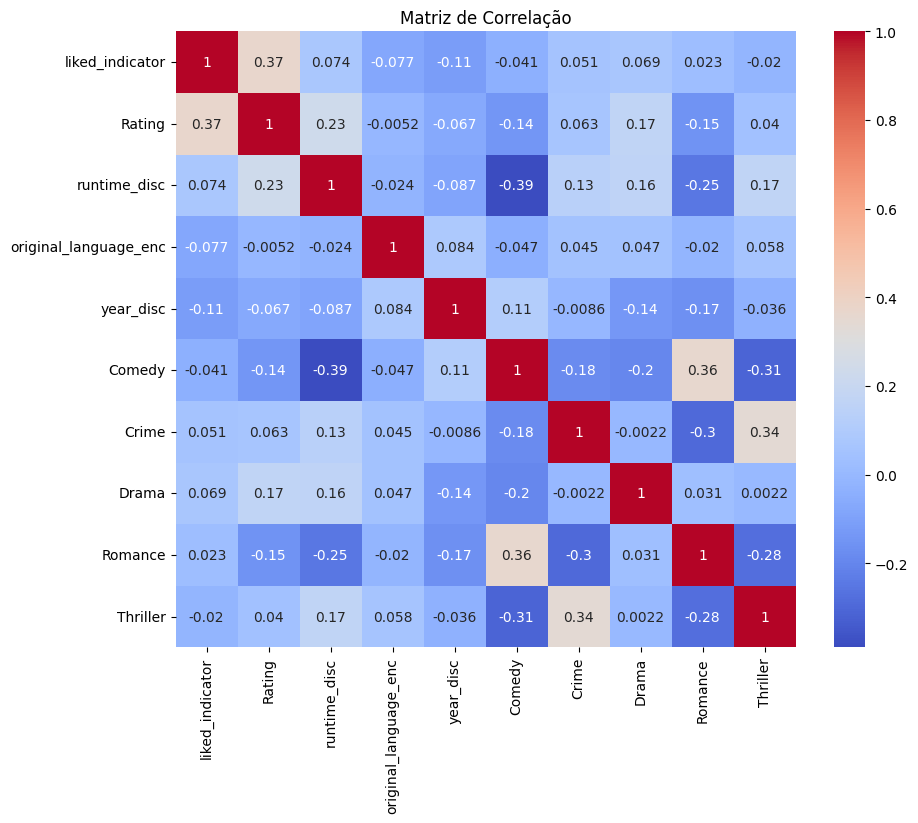

In [33]:
# Padronizando as Variáveis
scaler = StandardScaler()
meusfilmes_scaled = pd.DataFrame(scaler.fit_transform(meusfilmes_reducaodim), columns = meusfilmes_reducaodim.columns)

# Calculando a matriz de correlação
correlation_matrix = meusfilmes_scaled.corr()

# Plot
plt.figure(figsize = (10,8))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm')
plt.title('Matriz de Correlação')
plt.show()


A partir da matriz de correlação, podemos extrair algumas análises:

1. liked_indicator vs. Rating (0.365390):

    Existe uma correlação positiva moderada que demonstra que os filmes favoritos da usuária geralmente recebem maiores notas.

2. runtime_disc:

    O tempo de duração dos filmes possui uma correlação positiva com a avaliação, demonstrando que filmes mais longos são mais bem avaliados.

3. original_language_enc e year_disc:

    Não possuem grandes correlações com as demais variáveis, ou seja, o idioma dos filmes e ano de lançamento não têm grande influência nas preferências da usuária.

4. Rating:

    Para as avaliações observa-se que embora comédia e romance sejam dois dos gêneros que compõem o top 3 de aparições nos registros, a correlação com as avaliações é negativa, sugerindo que embora os gêneros sejam assistidos frequentemente, os filmes não necessariamente possuem grande qualidade na avaliação da usuária.

5. Drama:

    O gênero de drama, ao contrário das comédias românticas, possui uma correlação positiva com as avaliações e também com o tempo de duração, indicando uma preferência da usuária por dramas de longa duração.



Agora para o dataset que passou pelo processo de label enconding:

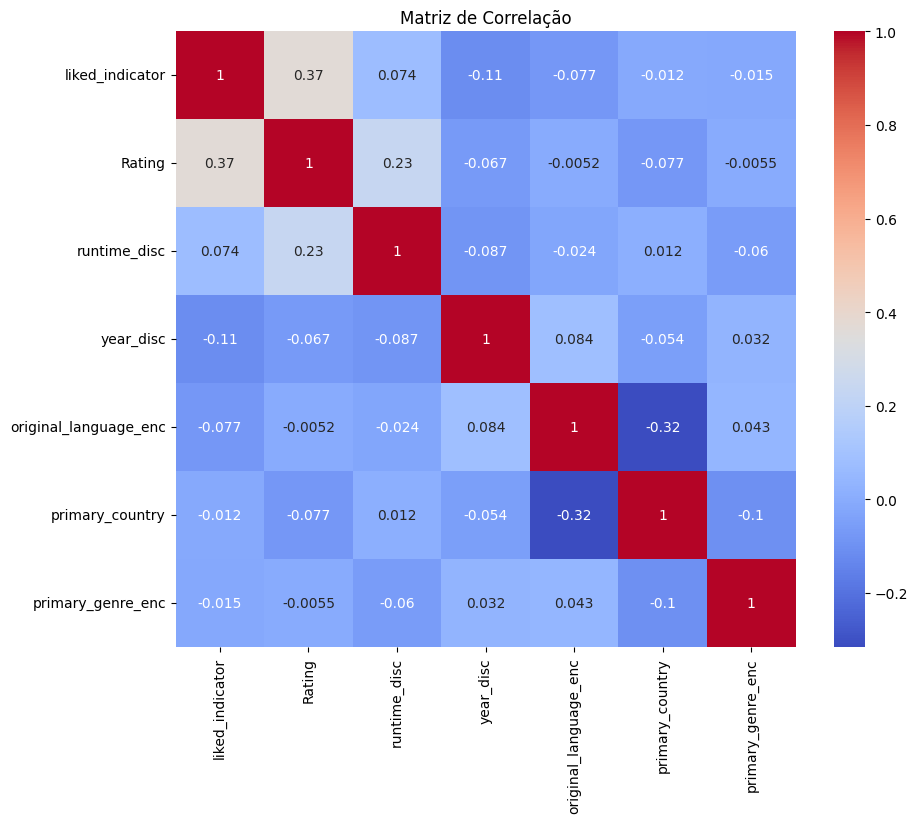

In [34]:
# Padronizando as Variáveis
scaler = StandardScaler()
meusfilmes_scaled = pd.DataFrame(scaler.fit_transform(meusfilmes_labelenc), columns = meusfilmes_labelenc.columns)

# Calculando a matriz de correlação
correlation_matrix = meusfilmes_scaled.corr()

# Plot
plt.figure(figsize = (10,8))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm')
plt.title('Matriz de Correlação')
plt.show()

O segundo dataset não produziu bons resultados ao analisar a matriz de correlação, observamos que nenhuma variável pareceu ter grande relevância nas preferências da usuária.

Nota-se também que esse dataset se tornou difícil de interpretar, pois não é mais possível fazer análises relacionadas a gêneros específicos. Dessa forma, o dataset que passou pelo tratamento de one-hot encoding deve ser selecionado para as etapas futuras do projeto.